### Setup

apt install requirements

In [3]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglew-dev is already the newest version (2.2.0-4).
libgl1-mesa-dev is already the newest version (23.0.4-0ubuntu1~22.04.1).
libosmesa6-dev is already the newest version (23.0.4-0ubuntu1~22.04.1).
software-properties-common is already the newest version (0.99.22.8).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
patchelf is already the newest version (0.14.3-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


Clone repo and install dependencies

In [4]:
%cd /content

!git clone https://github.com/jannerm/diffuser.git
%cd diffuser
!git checkout 13b4d404bdbd9d0d74c08d5a51ee39f84e765830
%cd /content

/content
Cloning into 'diffuser'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 653 (delta 153), reused 132 (delta 132), pack-reused 436
Receiving objects: 100% (653/653), 9.21 MiB | 6.54 MiB/s, done.
Resolving deltas: 100% (231/231), done.
/content/diffuser
Note: switching to '13b4d404bdbd9d0d74c08d5a51ee39f84e765830'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 13b4d40 Update environment.yml
/content

# Download Maze2D Pre-trained Diffuser Model

In [5]:
!curl -L -o maze2d-logs.zip https://www.dropbox.com/s/za14rwp8to1bosn/maze2d-logs.zip?dl=0
!unzip maze2d-logs.zip
!cp -r logs/ diffuser/scripts/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    61    0    61    0     0    173      0 --:--:-- --:--:-- --:--:--   172
100   318  100   318    0     0    443      0 --:--:-- --:--:-- --:--:--   443
100   491    0   491    0     0    300      0 --:--:--  0:00:01 --:--:--     0
100 79.8M  100 79.8M    0     0  26.0M      0  0:00:03  0:00:03 --:--:-- 92.5M


# Install diffusers pip package

In [8]:
!pip install gym==0.17.0
%cd diffuser
%pip install -f https://download.pytorch.org/whl/torch_stable.html \
                typed-argument-parser \
                scikit-image==0.17.2 \
                scikit-video==1.1.11 \
                gitpython \
                einops \
                pillow \
                free-mujoco-py \
                git+https://github.com/JannerM/d4rl.git@0e84a4d29db3ae501043215ce1d91843929f1949 \
                git+https://github.com/aravindr93/mjrl


%pip install -e .

  Created wheel for scikit-image: filename=scikit_image-0.17.2-cp310-cp310-linux_x86_64.whl size=33208282 sha256=1f8c643cfa3a05db03fd7ca9dd98ef26d1975e07c2d21eea38230875d2cc02cf
  Stored in directory: /root/.cache/pip/wheels/30/fc/f4/10c6987c3a9cb937913fa19f8290e91e6f66df2440c2af6130
  Created wheel for typed-argument-parser: filename=typed_argument_parser-1.9.0-py3-none-any.whl size=25615 sha256=2b2fa79a634fbe63546d154006cd90b713d37d5f8ee0ca6d2f3b059bd9fe73c6
  Stored in directory: /root/.cache/pip/wheels/f0/94/0f/9539f578bed7e1bd423c702e403712f5ee8989f831a71db000
  Created wheel for d4rl: filename=d4rl-1.1-py3-none-any.whl size=26410948 sha256=5b3033b27f4e58eaceeb062e7fb877c54e16aecd48505ab67e7a4610a156fa23
  Stored in directory: /root/.cache/pip/wheels/12/63/81/146564270eddcb114aa0406f09b5df98cdbe241cb0e40b009a
  Created wheel for mjrl: filename=mjrl-1.0.0-py3-none-any.whl size=61935 sha256=b5951bdf530ebc3062f569de2645720cbd845ad507b48c90de10995086c7166c
  Stored in directory: /tmp/

In [9]:
!sed -i 's/collections\.Mapping/collections.abc.Mapping/g' /content/diffuser/diffuser/utils/config.py
# !sed -i 's/args\.logbase/"\/content\/" + args.logbase/g' /content/diffuser/scripts/plan_maze2d.py


In [ ]:
# !python /content/diffuser/scripts/plan_maze2d.py --config config.maze2d --dataset maze2d-umaze-v1


# Imports

In [1]:
import json
import numpy as np
from os.path import join
import pdb


import diffuser.datasets as datasets
import diffuser.utils as utils
import pickle

# from diffuser.guides.policies import Policy
# class Parser(utils.Parser):
#     dataset: str = 'maze2d-umaze-v1'
#     config: str = 'config.maze2d'


# args = pickle.load(open('/content/args.pickle', 'rb'))

## Tweak Policy Class (Takes diffusion start timestep and seed trajectory as arguments)

In [2]:
from collections import namedtuple
# import numpy as np
import torch
import einops
import pdb

import diffuser.utils as utils
# from diffusion.datasets.preprocessing import get_policy_preprocess_fn

Trajectories = namedtuple('Trajectories', 'actions observations')
# GuidedTrajectories = namedtuple('GuidedTrajectories', 'actions observations value')

class Policy:

    def __init__(self, diffusion_model, normalizer):
        self.diffusion_model = diffusion_model
        self.normalizer = normalizer
        self.action_dim = normalizer.action_dim

    @property
    def device(self):
        parameters = list(self.diffusion_model.parameters())
        return parameters[0].device

    def _format_conditions(self, conditions, batch_size):
        conditions = utils.apply_dict(
            self.normalizer.normalize,
            conditions,
            'observations',
        )
        conditions = utils.to_torch(conditions, dtype=torch.float32, device='cuda:0')
        conditions = utils.apply_dict(
            einops.repeat,
            conditions,
            'd -> repeat d', repeat=batch_size,
        )
        return conditions

    def __call__(self, conditions, debug=False, batch_size=1, diffusion_start_timestep=64, seed_trajectory=None):


        conditions = self._format_conditions(conditions, batch_size)

        ## batchify and move to tensor [ batch_size x observation_dim ]
        # observation_np = observation_np[None].repeat(batch_size, axis=0)
        # observation = utils.to_torch(observation_np, device=self.device)

        ## run reverse diffusion process
        sample, diffusion_samples = self.diffusion_model(conditions, return_diffusion=True, diffusion_start_timestep=diffusion_start_timestep, seed_trajectory=seed_trajectory)
        sample = utils.to_np(sample)

        ## extract action [ batch_size x horizon x transition_dim ]
        actions = sample[:, :, :self.action_dim]
        actions = self.normalizer.unnormalize(actions, 'actions')
        # actions = np.tanh(actions)

        ## extract first action
        action = actions[0, 0]

        # if debug:
        normed_observations = sample[:, :, self.action_dim:]
        observations = self.normalizer.unnormalize(normed_observations, 'observations')

        # if deltas.shape[-1] < observation.shape[-1]:
        #     qvel_dim = observation.shape[-1] - deltas.shape[-1]
        #     padding = np.zeros([*deltas.shape[:-1], qvel_dim])
        #     deltas = np.concatenate([deltas, padding], axis=-1)

        # ## [ batch_size x horizon x observation_dim ]
        # next_observations = observation_np + deltas.cumsum(axis=1)
        # ## [ batch_size x (horizon + 1) x observation_dim ]
        # observations = np.concatenate([observation_np[:,None], next_observations], axis=1)

        trajectories = Trajectories(actions, observations)
        return action, trajectories
        # else:
        #     return action


## Tweak Diffusion Model (takes seed trajectory as an argument)

In [3]:
from diffuser.models.helpers import apply_conditioning
from diffuser.models.diffusion import GaussianDiffusion

@torch.no_grad()
def p_sample_loop_new(self, shape, cond, verbose=True, return_diffusion=False, diffusion_start_timestep=64, seed_trajectory=None):
    device = self.betas.device
    batch_size = shape[0]
    if seed_trajectory is None:
      x = torch.randn(shape, device=device)
    else:
      x = torch.tensor(seed_trajectory).to(device).float()
    x = apply_conditioning(x, cond, self.action_dim)

    if return_diffusion: diffusion = [x]

    progress = utils.Progress(self.n_timesteps) if verbose else utils.Silent()
    for i in reversed(range(0, self.n_timesteps)):
        if i > diffusion_start_timestep:
          print(f"Skipping t={i}")
          continue
        timesteps = torch.full((batch_size,), i, device=device, dtype=torch.long)
        x = self.p_sample(x, cond, timesteps)
        x = apply_conditioning(x, cond, self.action_dim)

        progress.update({'t': i})

        if return_diffusion: diffusion.append(x)

    progress.close()

    if return_diffusion:
        return x, torch.stack(diffusion, dim=1)
    else:
        return x


GaussianDiffusion.p_sample_loop = p_sample_loop_new

In [4]:
# logger = utils.Logger(args)
env = datasets.load_environment("maze2d-umaze-v1")
#---------------------------------- loading ----------------------------------#
diffusion_experiment = utils.load_diffusion("/content/logs/", "maze2d-umaze-v1", "diffusion/H128_T64", epoch="latest")
diffusion = diffusion_experiment.ema
dataset = diffusion_experiment.dataset
renderer = diffusion_experiment.renderer
policy = Policy(diffusion, dataset.normalizer)


[ utils/serialization ] Loaded config from /content/logs/maze2d-umaze-v1/diffusion/H128_T64/dataset_config.pkl

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-umaze-v1
    horizon: 128
    max_path_length: 40000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/serialization ] Loaded config from /content/logs/maze2d-umaze-v1/diffusion/H128_T64/render_config.pkl

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: maze2d-umaze-v1

[ utils/serialization ] Loaded config from /content/logs/maze2d-umaze-v1/diffusion/H128_T64/model_config.pkl

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 128
    transition_dim: 6

[ utils/serialization ] Loaded config from /content/logs/maze2d-umaze-v1/diffusion/H128_T64/diffusion_config.pkl

[utils/config ] Config: <class 'diffuser.models.diffusio

# Human Preference Trajectory. For now, we synthesize this. Late will be replaced with a Language Model

In [5]:
def interpolate_trajectory(trajectory):
    indices_128 = np.linspace(0, len(trajectory), 128)
    return np.array(
        [np.interp(indices_128, np.arange(len(trajectory)), trajectory[:, i]) for i in range(2)]
        ).T

import numpy as np
trajectory = np.array([(3, 3), (2, 3), (1, 3), (1, 2), (1, 1)])
trajectory = interpolate_trajectory(trajectory)

# Set the number of steps
num_steps = 128

# Set the frequency of the sinusoidal noise
frequency = 0.1
import matplotlib.pyplot as plt
# Generate sinusoidal noise
x = np.arange(num_steps)
sinusoidal_noise = 0.05 * np.sin(2 * np.pi * frequency * x)
sinusoidal_noise.shape
trajectory = trajectory + np.expand_dims(sinusoidal_noise, axis=1)
trajectory_vel = np.concatenate([np.diff(trajectory, axis=0), np.array([[0, 0]])], axis=0)
trajectory = np.concatenate([trajectory, trajectory_vel], axis=1)

conditions = policy._format_conditions({t: trajectory[t] for t in range(128)}, batch_size=1)
trajectory_normalized = np.array([conditions[t].cpu().numpy() for t in range(128)]).transpose(1, 0, 2)
trajectory_normalized.shape
trajectory_normalized = np.concatenate(
    [np.diff(trajectory_normalized[:, :, 0:2], axis=1, append=0) + np.diff(trajectory_normalized[:, :, 2:4], axis=1, append=0), trajectory_normalized], axis=2
)

## Visualize Human Preferences Trajectory

Saved 1 samples to: tmp.png


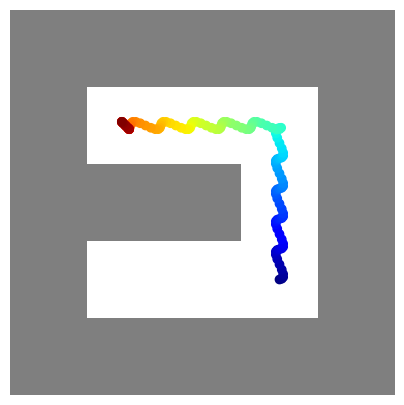

In [6]:
renderer.composite(savepath="tmp.png", paths=np.expand_dims(trajectory, axis=0), ncol=1)

## Intervene on diffusion at different time steps


Skipping t=63
Skipping t=62
Skipping t=61
Skipping t=60
Skipping t=59
Skipping t=58
Skipping t=57
Skipping t=56
Skipping t=55
Skipping t=54
Skipping t=53
Skipping t=52
Skipping t=51
Skipping t=50
Skipping t=49
Skipping t=48
Skipping t=47
Skipping t=46
Skipping t=45
Skipping t=44
Skipping t=43
Skipping t=42
Skipping t=41
Skipping t=40
Skipping t=39
Skipping t=38
Skipping t=37
Skipping t=36
Skipping t=35
Skipping t=34
Skipping t=33
Skipping t=32
Skipping t=31
Skipping t=30
Skipping t=29
Skipping t=28
Skipping t=27
Skipping t=26
Skipping t=25
Skipping t=24
Skipping t=23
Skipping t=22
Skipping t=21
Skipping t=20
Skipping t=19
Skipping t=18
Skipping t=17
Skipping t=16
Skipping t=15
Skipping t=14
Skipping t=13
Skipping t=12
Skipping t=11
Skipping t=10
Skipping t=9
Skipping t=8
Skipping t=7
Skipping t=6
Skipping t=5
Skipping t=4
Skipping t=3
Skipping t=2
Skipping t=1
Skipping t=0
                                                                                                    
Saved 1 samp

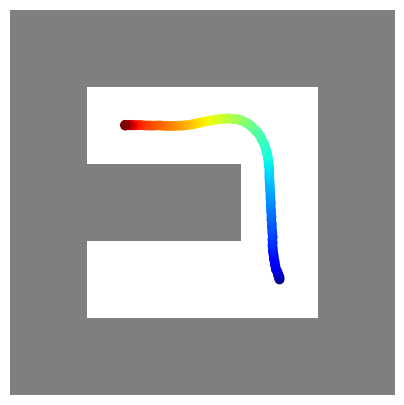

In [14]:
for diffusion_start_timestep in range(-1, 15, 1):
  env.reset()
  env.seed(42)
  # Set start position
  env.set_state(np.array([3, 3]), np.array([0, 0]))
  observation = env.state_vector().copy()

  ## set conditioning xy position to be the goal
  target = env._target
  cond = {
      diffusion.horizon - 1: np.array([*target, 0, 0]),
  }

  cond[0] = observation
  action, samples = policy(cond, batch_size=1, diffusion_start_timestep=diffusion_start_timestep, seed_trajectory=trajectory_normalized)
  actions = samples.actions[0]
  sequence = samples.observations[0]
  renderer.composite(f'/content/T={diffusion_start_timestep}.png', samples.observations, ncol=1)



## Visualize Diffused Trajectory

Text(0.5, 1.0, 'No Diffusion')

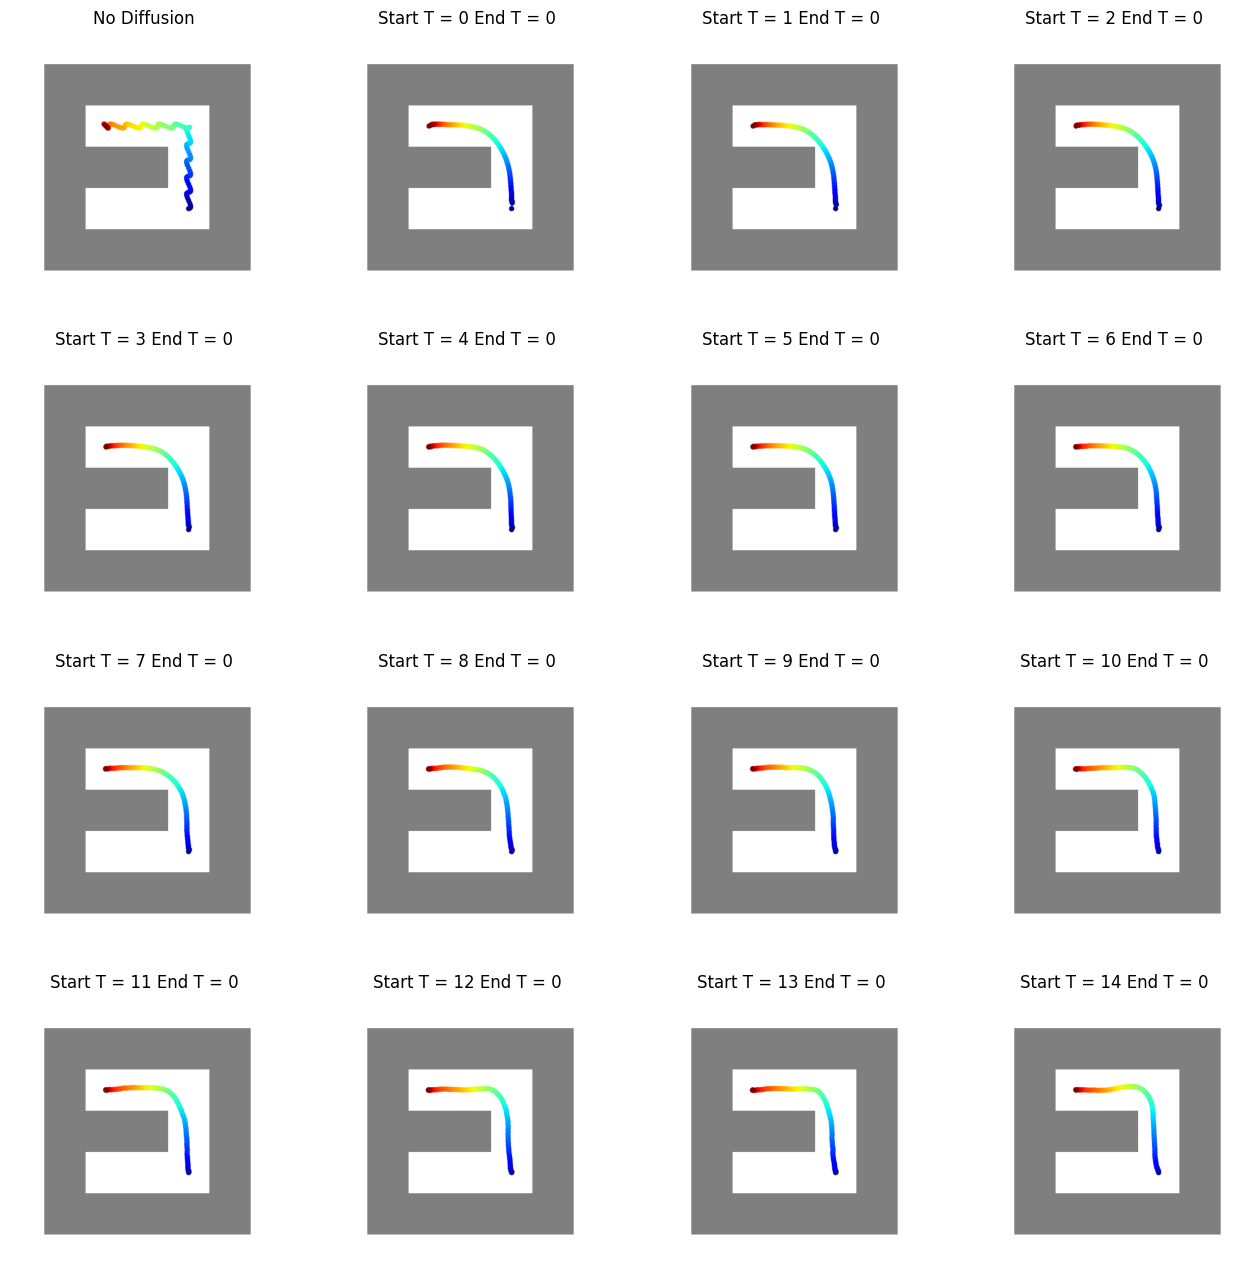

In [16]:
from PIL import Image
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i in range(16):
  row = i // 4
  col = i % 4
  ax[row][col].imshow(Image.open(f'/content/T={i-1}.png'))
  ax[row][col].set_title(f'Start T = {i-1} End T = 0')
  ax[row][col].axis('off')

ax[0][0].set_title('No Diffusion')

In [19]:
from google.colab import files
files.download("/content/project.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
!zip -r /content/project.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 25%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.12.11/ (stored 0%)
  adding: content/.config/logs/2023.12.11/14.25.07.026924.log (deflated 86%)
  adding: content/.config/logs/2023.12.11/14.25.16.062420.log (deflated 58%)
  adding: content/.config/logs/2023.12.11/14.24.56.854213.log (deflated 58%)
  adding: content/.config/logs/2023.12.11/14.25.26.231373.log (deflated 57%)
  adding: content/.config/logs/2023.12.11/14.24.28.856891.log (deflated 91%)
  adding: content/.config/logs/202